<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/EDA_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

Medical imaging is the process of creating visual representations of the interior of a body for clinical analysis as well as visual representation of the function of some organs or tissues.
They are widely used in hospitals and clinics to determine fractures and diseases. The medical images are read and interpreted by specialized medical professionals and their findings regarding each body of area examined are communicated via written Medical Reports. The process of writing medical reports usually takes around 5-10 minutes per report. In a day the doctors have to write medical reports that number in 100s which can take a lot of their time. The objective of this case study is to build a deep learning model that automatically write the impression part of medical report of chest X-rays and alleviate some of the burden of the medical professional. Here I will be taking a publicly available dataset from Indiana University which consists of chest X-ray images and reports (in XML format) which contain information regarding the findings and impression of the X-ray. The goal is to predict the impressions of the medical report attached to the images.

# **Metric Used**

Here we will be using [BLEU](https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1) score as  the metric. BLEU score compares each word in the predicted sentence and compare it to the reference sentence (It is also done in n-grams) and returns score based on how many words were predicted that were in the original sentence. BLEU score is not a good metric to compare the performance of translation since simililar words that have the same meaning will be penalized. So we will not only use n-gram BLEU score but also take a sample of the predicted captions and compare it to the original reference caption manually. 

# **Dataset Used**
Here I will be taking a publicly available dataset from Indiana University which consists of chest X-ray [images](https://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d) and [reports](https://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9) (in XML format) which contain information regarding the findings and impression of the X-ray. The goal is to predict the impressions of the medical report attached to the images.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm

# **Exploratory Data Analysis**

## **Images**

In [2]:
image_folder = '/content/drive/My Drive/Medical image Reporting/Images' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 7471


1)



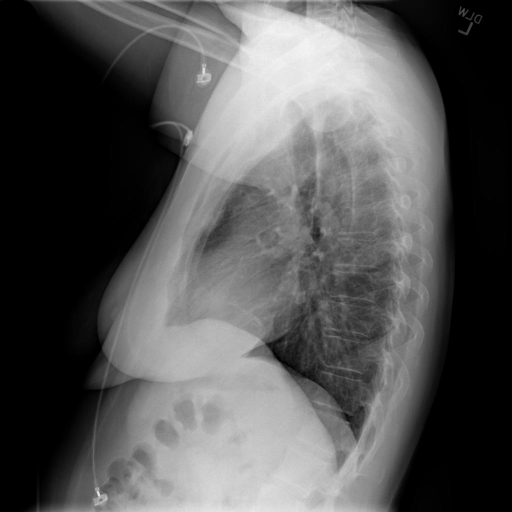

		 CXR1294_IM-0193-2001.png
2)



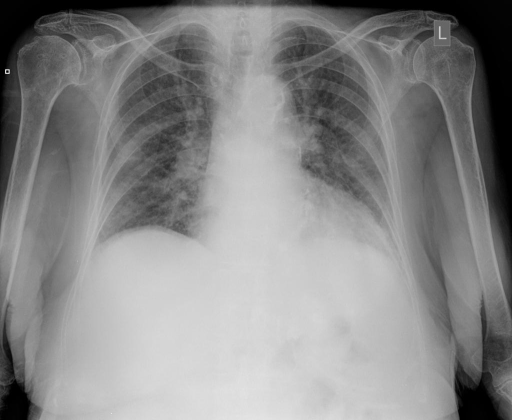

		 CXR2688_IM-1159-4004.png
3)



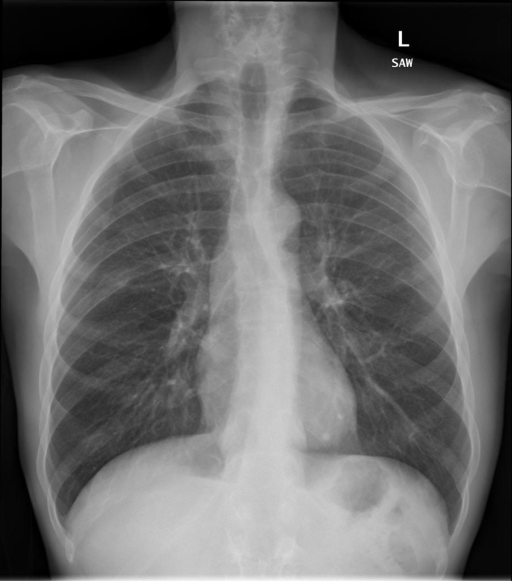

		 CXR3657_IM-1818-1001.png
4)



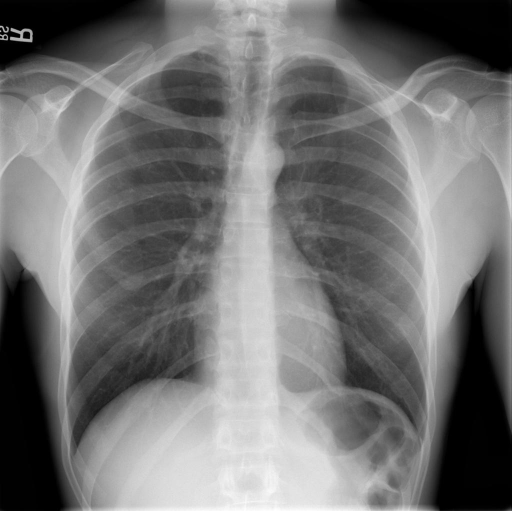

		 CXR429_IM-2070-1001.png
5)



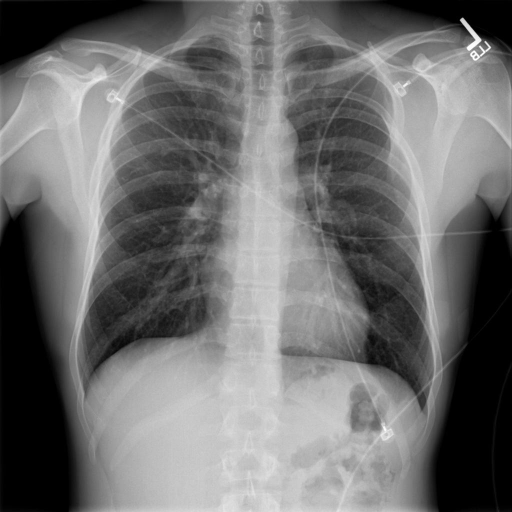

		 CXR3713_IM-1855-1001.png


In [3]:
#showing random 5 sample images
np.random.seed(420)
for i in range(5): #print 5 sample images
  k = np.random.choice(range(total_images))
  image_file = os.listdir(image_folder)[k]
  image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
  print("%i)\n"%(i+1))
  cv2_imshow(image)
  print("\t\t",image_file) #the image file name

We can see 5 sample images of the dataset. These are chest X_rays which are taken in  front and side view.

## **Reports**

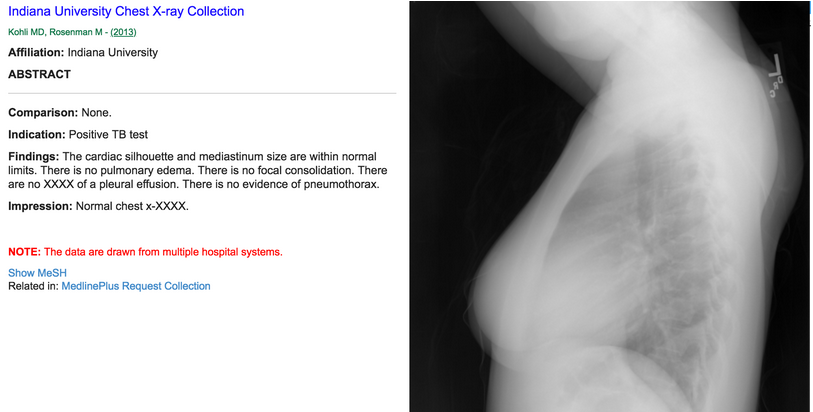

This is  a sample report. The report is stored in xml format. We will extract comparison, indication,findings and impression part of the report.

In [4]:
reports_folder = "/content/drive/My Drive/Medical image Reporting/Reports/ecgen-radiology"
total_reports = len(os.listdir(reports_folder))
print('The number of reports in the data are: %i'%(total_reports))

The number of reports in the data are: 3955


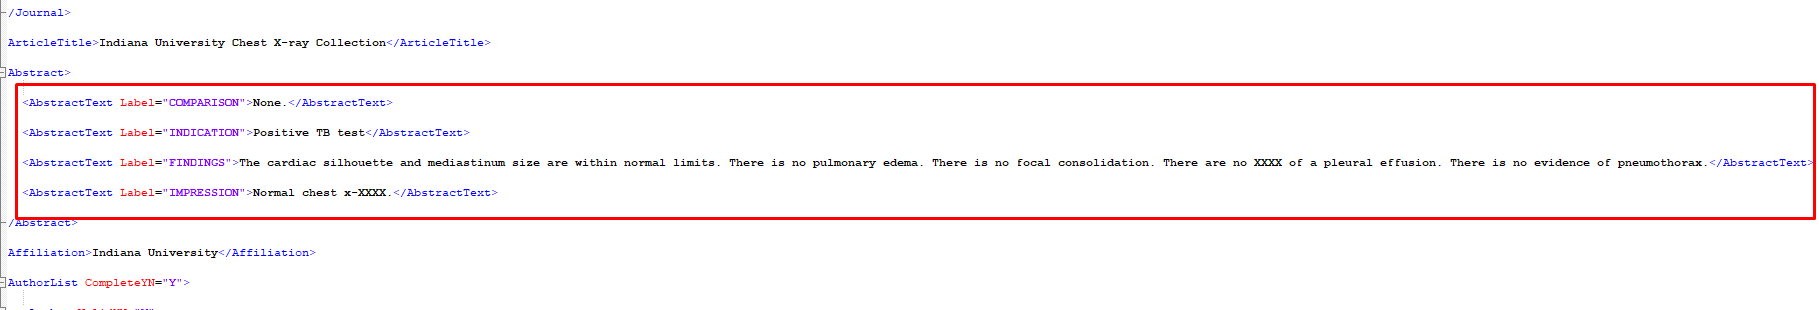

In the xml file, report information is stored like this.

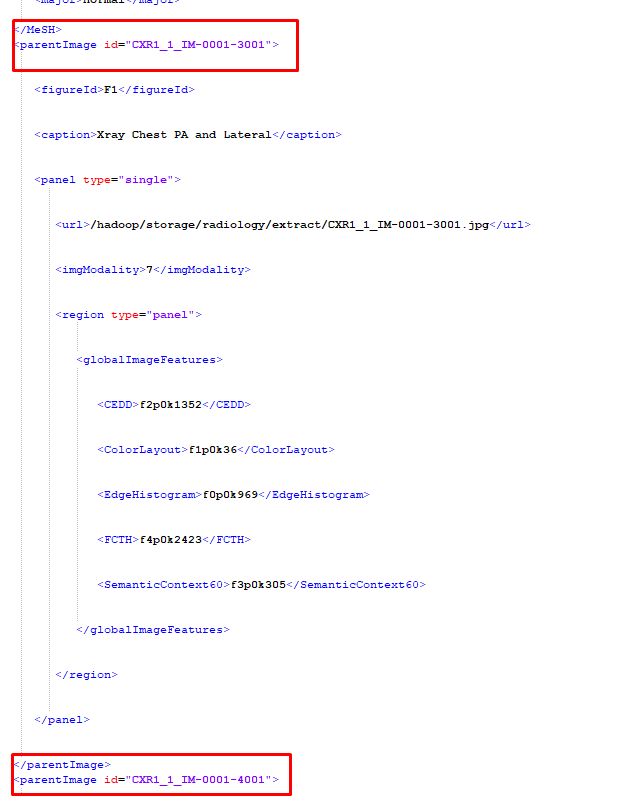

These are the two image files that are associated with the report.

We will extract all the information part ie comparison, indication, findings and impression part of the report and the corresponding 2 images of the concerned report to a dataframe with xml report file name. 

In [ ]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


def get_info(xml_data,info): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  regex = r"\""  +info +r"\".*" 
  k = re.findall(regex,xml_data)[0] #finding info part of the report

  regex = r"\>.*\<"
  k = re.findall(regex,k)[0] #removing info string and /AbstractText>'

  regex = r"\d." 
  k = re.sub(regex,"",k) #removing all values like "1." and "2." etc

  regex = r"X+"
  k = re.sub(regex,"",k) #removing words like XXXX

  regex = r" \."
  k = re.sub(regex,"",k) #removing singular fullstop ie " ."

  regex = r"[^.a-zA-Z]" 
  k = re.sub(regex," ",k) #removing all special characters except for full stop

  regex = r"\."
  k = re.sub(regex," .",k) #adding space before fullstop
  k = decontracted(k) #perform decontraction
  k = k.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
  k = " ".join(k.split()) #removes unwanted spaces
  if k=="": #if the resulting sentence is an empty string return null value
    k = np.nan
  return k

def get_df():
  """
  Given an xml data, it will extract the two image names and corresponding info text and returns a dataframe
  """
  im1 = [] #there are 2 images associated with a report
  im2 = []
  #stores info
  comparisons = []
  indications = []
  findings = []
  impressions = [] 
  report = [] #stores xml file name
  for file in tqdm(os.listdir(reports_folder)):
    report_file = os.path.join(reports_folder,file)
    with open(report_file, 'r') as f:  #reading the xml data
      data = f.read()
  
    regex = r"parentImage id.*" #getting all the image names
    k  = re.findall(regex,data)

    if len(k)==2: #some are having only 1 image
      regex = r"\".*\"" #getting the name
      image1 = re.findall(regex,k[0])[0]
      image2 = re.findall(regex,k[1])[0]
      regex = r"\"" #removing "
      image1 = re.sub(r"\"","",image1)
      image2 = re.sub(r"\"","",image2)

      image1 = image1.strip()+".png"
      image2 = image2.strip()+".png"
    
    else:
      regex = r"\".*\"" #getting the name
      try: #if the exception is raised means no image file name was found
        image1 = re.findall(regex,k[0])[0]
        image1 = re.sub(r"\"","",image1) #removing "
        image2 = np.nan

        image1 = image1.strip()+".png"
      except:
        image1 = np.nan
        image2 = np.nan

    
    try: #assigning null values to the ones that don't have the concerned info
      comparison = get_info(data, "COMPARISON")
    except:
      comparison = np.nan;

    try: #assigning null values to the ones that don't have the concerned info
      indication = get_info(data, "INDICATION")
    except:
      indication = np.nan;

    try: #assigning null values to the ones that don't have the concerned info
      finding = get_info(data,"FINDINGS")
    except:
      finding = np.nan;

    try: #assigning null values to the ones that don't have the concerned info
      impression = get_info(data, "IMPRESSION")
    except:
      impression = np.nan;
  
    report.append(file) #xml file name
    im1.append(image1)
    im2.append(image2)
    comparisons.append(comparison)
    indications.append(indication)
    findings.append(finding)
    impressions.append(impression)

  df = pd.DataFrame({"image_1":im1,"image_2":im2,"comparison":comparisons,"indication":indications,"findings":findings,"impression":impressions,"xml file name":report})
  return df

In [ ]:
%%time
df = get_df()

100%|██████████| 3955/3955 [16:51<00:00,  3.91it/s]

CPU times: user 7.46 s, sys: 1.78 s, total: 9.24 s
Wall time: 16min 51s


In [ ]:
# df.to_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df.pkl")
df.shape

(3955, 7)

In [ ]:
df.head()

,image_1,image_2,comparison,indication,findings,impression,xml file name
0,CXR597_IM-2189-2001.png,NaN,none,year old female with right sided pleuritic che...,there are bilateral lower lobe opacities . no ...,bilateral lower lobe opacities . the appearanc...,597.xml
1,CXR601_IM-2192-1001.png,CXR601_IM-2192-1002.png,none .,year old male shortness of breath . reported h...,right dual lumen internal jugular central veno...,bilateral lower lung airspace disease right gr...,601.xml
2,CXR600_IM-2192-1001.png,CXR600_IM-2192-2001.png,none .,year old male . shortness of breath . syncope ...,the cardiomediastinal silhouette is normal in ...,negative for acute abnormality .,600.xml
3,CXR605_IM-2194-1001.png,CXR605_IM-2194-1002.png,NaN,NaN,the heart is normal in size . the mediastinum ...,small nodular opacity in left upper lung may b...,605.xml
4,CXR59_IM-2184-1001.png,CXR59_IM-2184-2001.png,NaN,year old male with history of cell back pain,the cardiac silhouette mediastinum and pulmona...,no acute abnormalities are seen .,59.xml


Now we check for missing values.

In [ ]:
print("columns\t\t%missing values")
print('-'*30)
print(df.isnull().sum()*100/df.shape[0] )#percentage missing values

columns		%missing values
------------------------------
image_1           2.629583
image_2          18.887484
comparison       33.501896
indication        6.321113
findings         13.400759
impression        0.859671
xml file name     0.000000
dtype: float64


We can see that there are many missing values in the data. We could remove all rows where image_1 and impression values are null since they represent below 5% of the total datapoints.

In [ ]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(3955-df.shape[0],df.shape[0]))

135 datapoints were removed.
Final no. of datapoints: 3820


We removed 3.41% datapoints in total.

There are missing values in image_2. For that we can use the same image file in image_1. We will also check for image size for both of them.

In [ ]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
im1_size = []
im2_size = []
for index,row in df.iterrows():
  im1_size.append( cv2.imread(os.path.join(image_folder,row.get('image_1'))).shape[:2])
  im2_size.append(cv2.imread(os.path.join(image_folder,row.get('image_2'))).shape[:2])

CPU times: user 36.2 s, sys: 3.2 s, total: 39.4 s
Wall time: 54.2 s


In [ ]:
df['im1_height'] = [i[0] for i in im1_size]
df['im1_width'] = [i[1] for i in im1_size]
df['im2_height'] = [i[0] for i in im2_size]
df['im2_width'] = [i[1] for i in im2_size]

In [13]:
df.head(2)

,image_1,image_2,comparison,indication,findings,impression,xml file name,im1_height,im1_width,im2_height,im2_width
0,CXR597_IM-2189-2001.png,CXR597_IM-2189-2001.png,none,year old female with right sided pleuritic che...,there are bilateral lower lobe opacities . no ...,bilateral lower lobe opacities . the appearanc...,597.xml,512,512,512,512
1,CXR601_IM-2192-1001.png,CXR601_IM-2192-1002.png,none .,year old male shortness of breath . reported h...,right dual lumen internal jugular central veno...,bilateral lower lung airspace disease right gr...,601.xml,516,512,751,512


In [14]:
# df.to_pickle("/content/drive/My Drive/Medical image Reporting/df_final.pkl")
df = pd.read_pickle("/content/drive/My Drive/Medical image Reporting/df_final.pkl")
df.shape

(3820, 11)

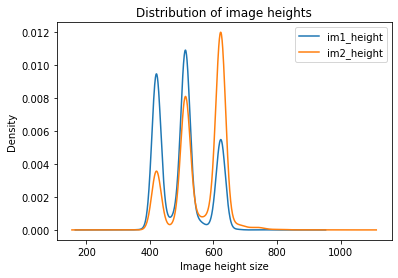



Value Counts of image_1 heights:

420    1087
512     898
624     598
511     225
618      78
Name: im1_height, dtype: int64

 ************************************************** 

Value Counts of image_2 heights:

624    1363
512     699
420     409
511     208
618      85
Name: im2_height, dtype: int64


In [6]:
ax = df[['im1_height','im2_height']].plot(kind='kde')
ax.set_title("Distribution of image heights")
ax.set_xlabel("Image height size")
plt.show()

print("\n\nValue Counts of image_1 heights:\n")
print(df.im1_height.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 heights:\n")
print(df.im2_height.value_counts()[:5])

We can observe that 420 is the most common height for image_1 while for image_2 is 624. The next common for both of the images is 512.

In [7]:
print("Value Counts of image_1 widths:\n")
print(df.im1_width.value_counts()[:5])
print("\n","*"*50,"\n")
print("Value Counts of image_2 widths:\n")
print(df.im2_width.value_counts()[:5])

Value Counts of image_1 widths:

512    3820
Name: im1_width, dtype: int64

 ************************************************** 

Value Counts of image_2 widths:

512    3820
Name: im2_width, dtype: int64


Width for both of the images have only 1 unique value for all datapoints and that is 512. Since pretrained models are modelled for square-sized images we can choose 512\*512 as the specified size of the image. Hence we can resize all images into 512\*512 shape.

Now we will print some sample datapoints with corresponding images and captions associated with that datapoint.

## **Sample Images + Caption**

In [8]:
def show_image_captions(df = df,image_folder = image_folder,sample = 3):
  """
  given the df, samples datapoints and prints the images and caption
  df: dataframe
  image_folder: folder which contains images
  """
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



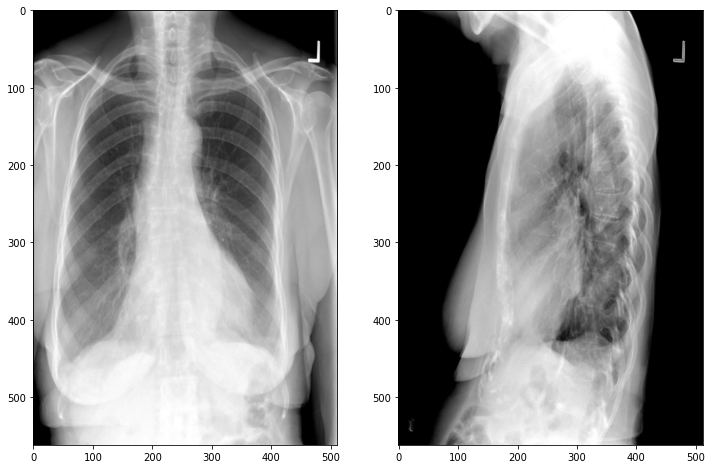


 Comparison:  comparison

 Indication:  shortness of breath

 Findings:  nan

 Impression:  mild cardiomegaly as before with no effusions or overt evidence of chf . large lung volumes as before . no acute airspace disease . stable mediastinal contour . no acute abnormalities since the previous chest radiograph . 

 ****************************************************************************************************************************************************** 


2)



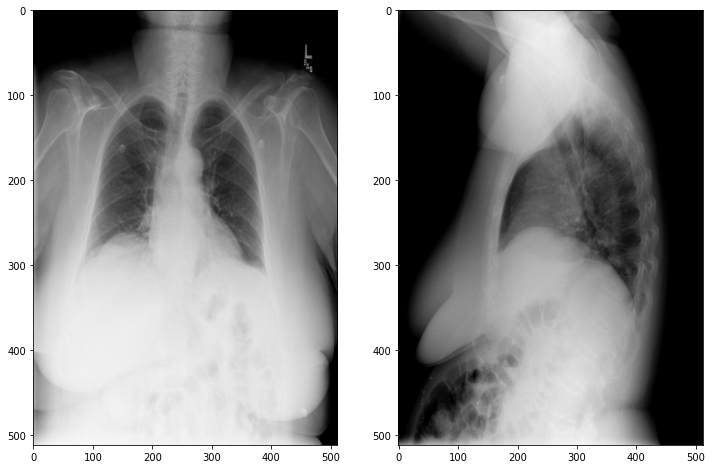


 Comparison:  none

 Indication:  distress

 Findings:  normal cardiomediastinal contours . low lung volumes with minimal left basilar opacities . no pneumothorax or pleural effusions .

 Impression:  minimal left basilar atelectasis versus infiltrate . low lung volumes . 

 ****************************************************************************************************************************************************** 


3)



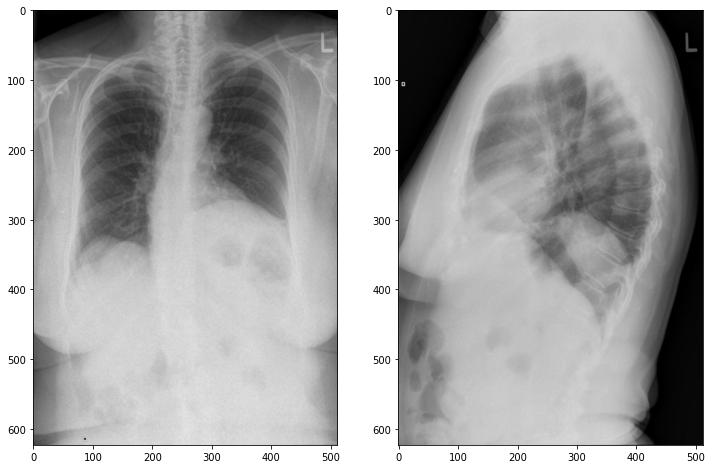


 Comparison:  .

 Indication:  abdominal pain right upper quadrant .

 Findings:  the heart size and pulmonary vascularity appear within normal limits . the lungs are free of focal airspace disease . no pleural effusion or pneumothorax is seen . the left hemidiaphragm is elevated . this is unchanged . no focal airspace disease is seen . no pneumothorax or pleural effusion is noted . there is eventration of the right hemidiaphragm .

 Impression:  continued elevation of the left hemidiaphragm . no evidence of active disease . 

 ****************************************************************************************************************************************************** 




In [9]:
#showing sample 3 datapoints
show_image_captions()

We can see that indications are patients medical complaints while findings are the obervations from X-ray while impression is inference obtained. In this case study, I will try to predict the impression part of the medical report given the two images.

### **Wordcloud of Impressions**

In [ ]:
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = df.loc[:,'impression'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

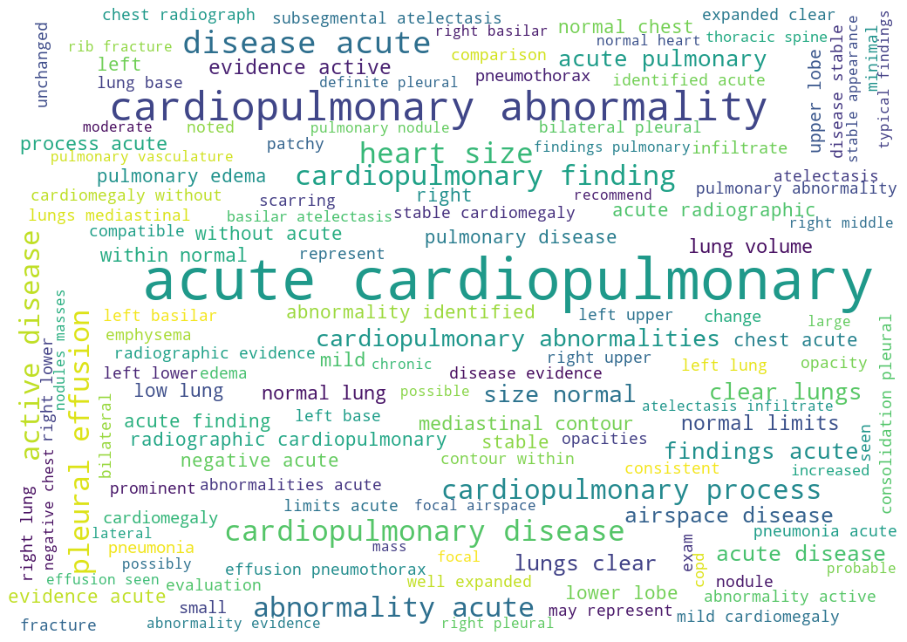

In [ ]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()